In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from mpl_toolkits.mplot3d import Axes3D

### preliminary


In [3]:
x=[0,1,2,3]
kx=np.fft.fft(x)
print(x, kx)

[0, 1, 2, 3] [ 6.+0.j -2.+2.j -2.+0.j -2.-2.j]


### constant delta on the grid transform

In [4]:
x = np.linspace(-1,1,10)
y = np.linspace(-1,1,10)
z = np.linspace(-1,1,10)

spacing = x[1]-x[0]

X, Y, Z = np.meshgrid(x, y, z)

vol = len(x)*len(y)*len(z)
print(spacing)
print(vol)

0.2222222222222222
1000


Text(0.5, 0.92, 'congifuration space')

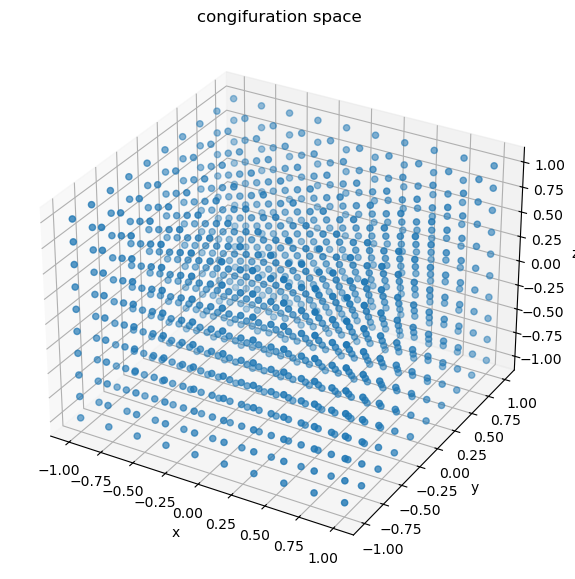

In [5]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('congifuration space')

In [6]:
grid = np.array([X,Y,Z])
print(grid.shape)

(3, 10, 10, 10)


In [7]:
kx = np.fft.fftfreq(len(x), spacing)
ky = np.fft.fftfreq(len(y), spacing)
kz = np.fft.fftfreq(len(z), spacing)

print(kx.shape, ky.shape, kz.shape)

kxs, kys, kzs = np.meshgrid(kx,ky,kz, indexing='ij')

print(kxs.shape, kys.shape, kzs.shape)

(10,) (10,) (10,)
(10, 10, 10) (10, 10, 10) (10, 10, 10)


Text(0.5, 0.92, 'fourier space')

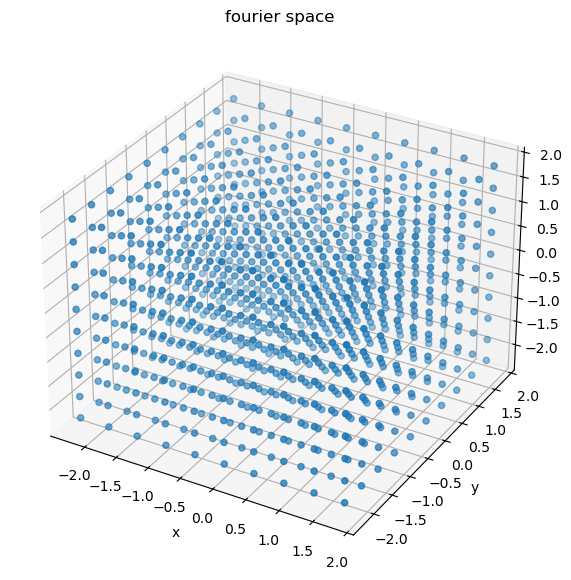

In [8]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kxs,kys,kzs)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('fourier space')

(10, 10, 10)


Text(0.5, 0.92, 'delta in config space')

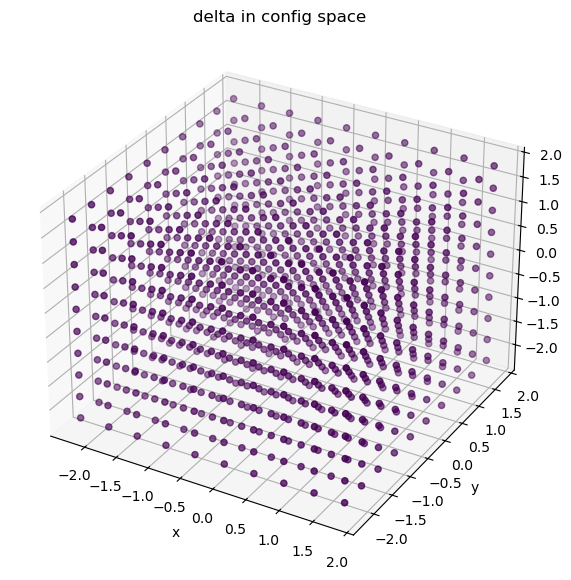

In [9]:
## define a constant overdensity field on the grid
delta = np.full_like(X, 3)
print(delta.shape)

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kxs,kys,kzs, c=delta)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('delta in config space')

(10, 10, 10)


/Users/edoardo/miniconda3/envs/acc-env/lib/python3.9/site-packages/matplotlib/axes/_axes.py:4458: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


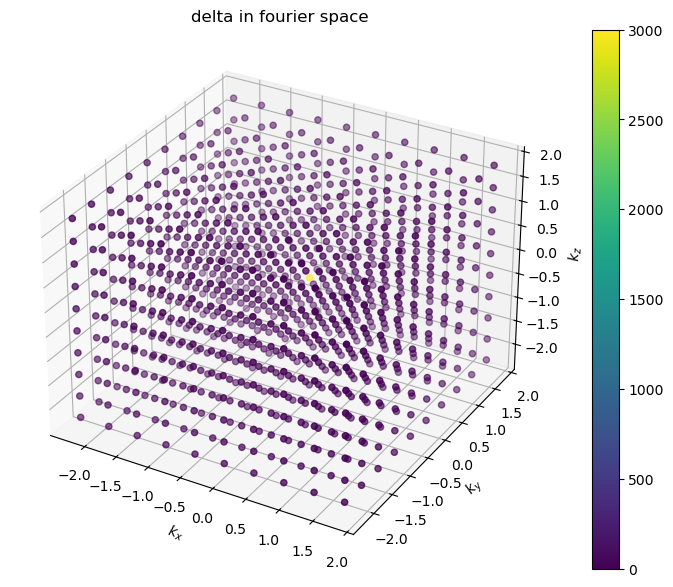

In [10]:
delta_transform = np.fft.fftn(delta)
print(delta.shape)

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(kxs,kys,kzs, c=delta_transform)
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')
ax.set_title('delta in fourier space')

plt.colorbar(scp)

Remember that $\mathcal{F}[const]=\delta_D (0)$: $\delta(k)$ is zero everywhere except in the origin

In [11]:
## computing P(k)=delta delta
Pk = vol * np.array(np.abs(delta_transform))**2
print(Pk.shape)

(10, 10, 10)


In [12]:
print(np.max(Pk))

9000000000.0


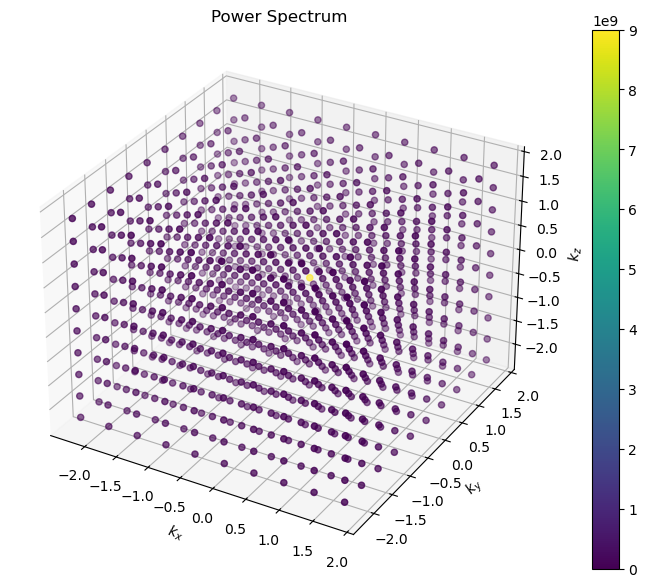

In [13]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(kxs,kys,kzs, c=Pk)
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')
ax.set_title('Power Spectrum')
plt.colorbar(scp)

In [14]:
## computing norm of the wavevectors

k_norm = np.sqrt(kxs**2+kys**2+kzs**2)
print(k_norm.shape)
print(k_norm.max())

(10, 10, 10)
3.897114317029974


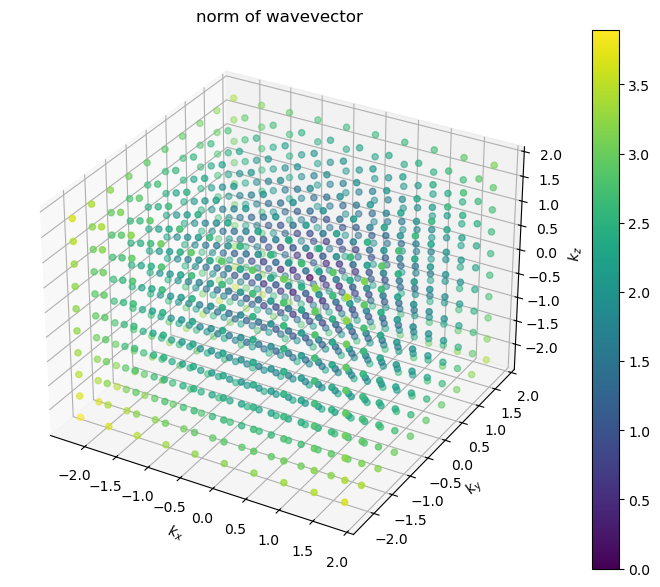

In [15]:
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(kxs,kys,kzs, c=k_norm)
ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')
ax.set_title('norm of wavevector')
plt.colorbar(scp)

Now I need to bin P(k): consider bins with the same abs(k) within a certain range and average P(k) in these bins

In [16]:
kN = 2 * np.pi / spacing              # max frequency based on spacing
kF = 2 * np.pi / len(x)               # min frequency based on side length

print(kN, kF)

# Define the edges for the wavevector bins
k_bin_edges = np.arange(0, k_norm.max() + kF, kF)    # Edges of the bins in abs(k)

print(k_bin_edges)

28.274333882308138 0.6283185307179586
[0.         0.62831853 1.25663706 1.88495559 2.51327412 3.14159265
 3.76991118 4.39822972]


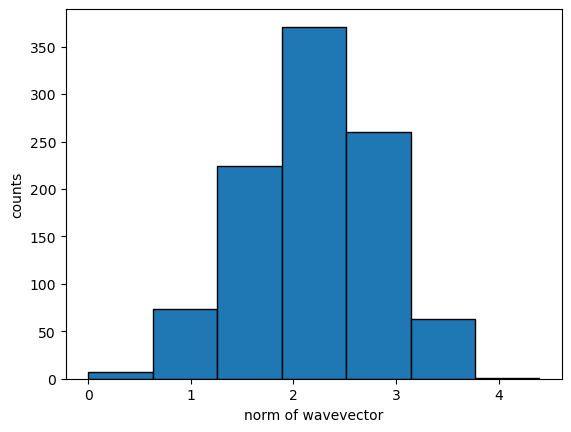

In [17]:
# Plot the histogram
plt.hist(k_norm.flatten(), k_bin_edges, edgecolor='black')
plt.xlabel('norm of wavevector')
plt.ylabel('counts')
plt.show()

Compute the binned Power spectrum averaging on circles in k-space, that is on cells where the norm of k is within a certain range

In [18]:
# Initialize arrays to store the bin values and the mean values of k_norm and Pk within each bin
k_bin = np.zeros(len(k_bin_edges) - 1)
pk_meas = np.zeros(len(k_bin_edges) - 1)

# Loop through each bin edge
for i in range(len(k_bin_edges)-1):
    # Find indices where the values of k_norm fall within the range defined by the bin edges
    indices_in_bin = np.where((k_norm.flatten() >= k_bin_edges[i]) & (k_norm.flatten() < k_bin_edges[i + 1]))[0]
    
    # Calculate the mean value of k_norm within the bin
    k_bin[i] = np.mean(k_norm.flatten()[indices_in_bin])
    
    # Calculate the mean value of Pk within the bin
    pk_meas[i] = np.mean(Pk.flatten()[indices_in_bin])


In [19]:
#mask=[2*n for n in range(0, int(len(k_bin)/2))]
#xticks=k_bin[mask]

([<matplotlib.axis.XTick at 0x147f27970>,
 [Text(0.38571428571428573, 0, '0.386'),
  Text(0.9442724259880909, 0, '0.944'),
  Text(1.5974788106984457, 0, '1.597'),
  Text(2.200532195071098, 0, '2.201'),
  Text(2.7687022912601633, 0, '2.769'),
  Text(3.309195249999989, 0, '3.309'),
  Text(3.897114317029974, 0, '3.897')])

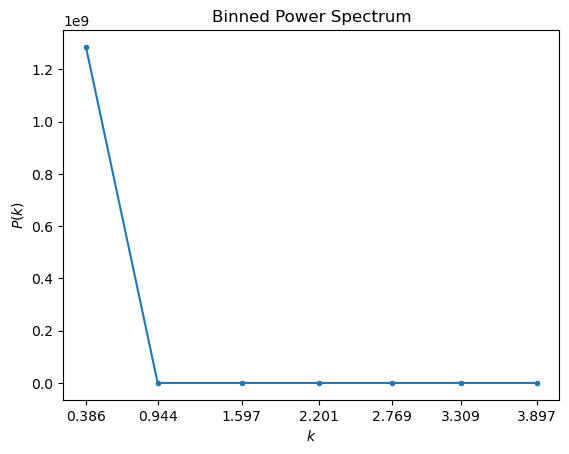

In [20]:
plt.plot(k_bin,pk_meas, marker = '.')
plt.title('Binned Power Spectrum')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.xticks(k_bin)

### digitize (does not work dunno why)
This can also be achieved using a np histogram object and the np.digitise function

In [21]:
k_hist, k_bin_edges = np.histogram(k_norm, bins=np.arange(0, k_norm.max()+kF, kF))

In [22]:
k_bin_v2 = np.zeros(len(k_bin_edges) - 1)
pk_meas_v2 = np.zeros(len(k_bin_edges) - 1)

# Digitize the values of k_norm to determine the bin indices
bin_indices = np.digitize(k_norm.flatten(), k_bin_edges) - 1  # Subtract 1 to match 0-based indexing

# Iterate over each bin
for i in range(len(k_bin_edges) - 1):
    # Find indices where the bin index matches the current bin
    indices_in_bin = np.where(bin_indices == i)[0]

    # Calculate the mean value of k_norm within the bin
    if len(indices_in_bin) > 0:
        k_bin_v2[i] = np.mean(k_norm.flatten()[indices_in_bin])

        # Calculate the mean value of Pk within the bin
        if k_hist[i] != 0:  # avoid division by zero
            pk_meas_v2[i] /= k_hist[i]

[1.28571429e+09 1.41909681e-25 1.80311064e-27 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[0. 0. 0. 0. 0. 0. 0.]


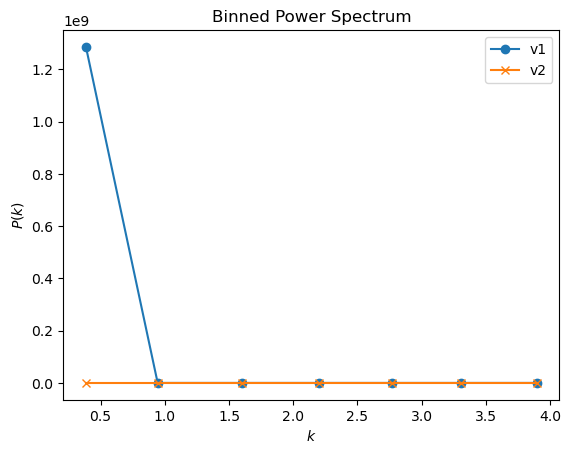

In [23]:
print(pk_meas)
print(pk_meas_v2)
plt.plot(k_bin,pk_meas, marker = 'o', label='v1')
plt.plot(k_bin_v2,pk_meas_v2, marker = 'x', label='v2')
plt.title('Binned Power Spectrum')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.legend()

In [24]:
import sys
import os
sys.path.append(os.path.relpath('/Users/edoardo/AstroCosmoComputational/Students/MaraglianoEdo/'))  
from pyACC.clustering import power_spectrum as PS

## clustering module test

In [25]:
pk_meas_v3, k_bin_v3 = PS.compute_power_spectrum([x,y,z], delta)

[1.28571429e+09 1.41909681e-25 1.80311064e-27 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


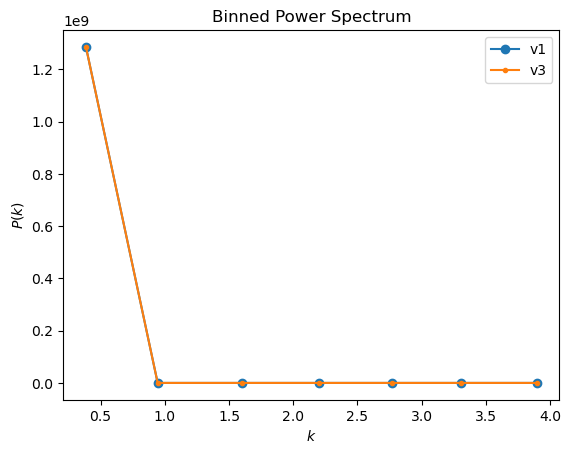

In [26]:
print(pk_meas)
plt.plot(k_bin,pk_meas, marker = 'o', label='v1')
plt.plot(k_bin_v3,pk_meas_v3, marker = '.', label='v3')
plt.title('Binned Power Spectrum')
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.legend()

## cic smoothing

In [45]:
def cic_interpolator(particles, masses, grid_shape):
    """
    Inputs:
    particles: 2D array of positions (len(masses), 3)
    masses: 1D array of masses
    grid_shape: tuple of 3 integers defining the shape of the grid (nx, ny, nz)

    Returns:
    rho: 3D array of density values with shape grid_shape
    """
    nx, ny, nz = grid_shape
    rho = np.zeros(grid_shape, dtype=np.float64)

    for p, m in zip(particles, masses):
        i, j, k = np.floor(p).astype(int)
        dx, dy, dz = p - [i, j, k]
        tx, ty, tz = 1 - dx, 1 - dy, 1 - dz

        # Ensure indices are within bounds
        i0, j0, k0 = i % nx, j % ny, k % nz
        i1, j1, k1 = (i + 1) % nx, (j + 1) % ny, (k + 1) % nz

        # Add contributions to the neighboring grid points
        rho[i0, j0, k0] += m * tx * ty * tz
        rho[i1, j0, k0] += m * dx * ty * tz
        rho[i0, j1, k0] += m * tx * dy * tz
        rho[i1, j1, k0] += m * dx * dy * tz
        rho[i0, j0, k1] += m * tx * ty * dz
        rho[i1, j0, k1] += m * dx * ty * dz
        rho[i0, j1, k1] += m * tx * dy * dz
        rho[i1, j1, k1] += m * dx * dy * dz

    return rho


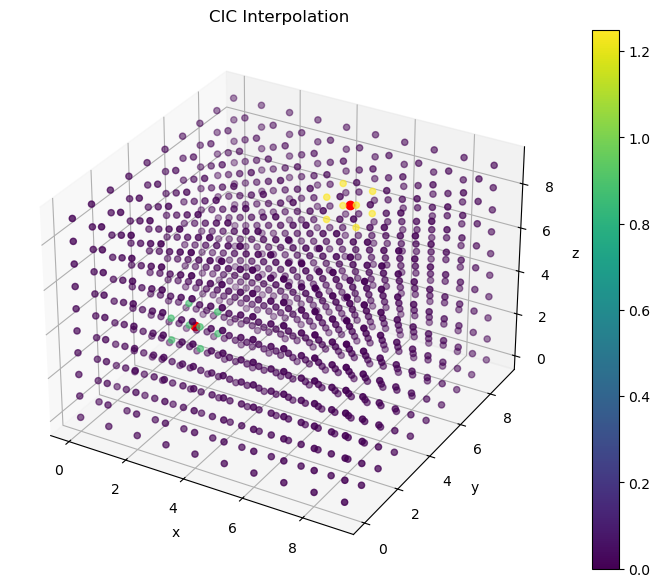

In [55]:
# Example usage:
particles = np.array([[2.5, 2.5, 3.5], [5.5,6.5,7.5]])
masses = np.array([7.0, 10.0])
grid_shape = (10, 10, 10)
rho = cic_interpolator(particles, masses, grid_shape)

# Plotting the result
xs, ys, zs = np.meshgrid(np.arange(0, grid_shape[0], 1), np.arange(0, grid_shape[1], 1), np.arange(0, grid_shape[2], 1), indexing='ij')

fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111, projection='3d')
scp = ax.scatter(xs.flatten(), ys.flatten(), zs.flatten(), c=rho.flatten(), cmap='viridis')
ax.plot(particles[:,0], particles[:,1], particles[:,2], color='red', marker='o', linestyle='None')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('CIC Interpolation')
plt.colorbar(scp)
plt.show()

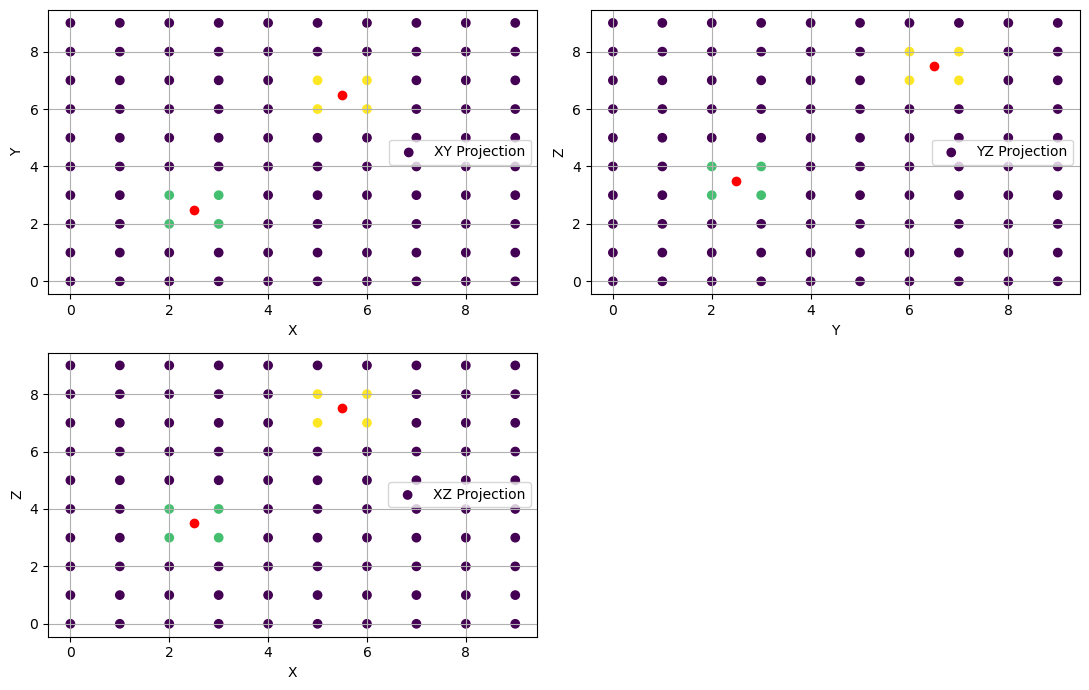

In [56]:
# 2D projection on XY plane
fig = plt.figure(figsize=(11,7))

ax_xy = fig.add_subplot(221)
ax_xy.scatter(xs.mean(axis=2), ys.mean(axis=2), c=rho.mean(axis=2), label='XY Projection')
ax_xy.scatter(particles[:,0], particles[:,1], color='red', marker='o')
ax_xy.set_xlabel('X')
ax_xy.set_ylabel('Y')
ax_xy.legend()
ax_xy.grid(True)

# 2D projection on YZ plane
ax_yz = fig.add_subplot(222)
ax_yz.scatter(ys.mean(axis=0), zs.mean(axis=0), c=rho.mean(axis=0), cmap='viridis', label='YZ Projection')
ax_yz.scatter(particles[:,1], particles[:,2], color='red', marker='o', linestyle='None')
ax_yz.set_xlabel('Y')
ax_yz.set_ylabel('Z')
ax_yz.legend()
ax_yz.grid(True)

# 2D projection on XZ plane
ax_xz = fig.add_subplot(223)
ax_xz.scatter(xs.mean(axis=1), zs.mean(axis=1), c=rho.mean(axis=1), cmap='viridis', label='XZ Projection')
ax_xz.scatter(particles[:,0], particles[:,2], color='red', marker='o', linestyle='None')
ax_xz.set_xlabel('X')
ax_xz.set_ylabel('Z')
ax_xz.legend()
ax_xz.grid(True)

# Show the plot
plt.tight_layout()
plt.show()